<a href="https://colab.research.google.com/github/fskanderdh/Product-Logistics/blob/main/Woowa_Payment_Model_with_Rush.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
from google.cloud import bigquery
from google.cloud.bigquery import magics
%load_ext google.cloud.bigquery

In [ ]:
client = bigquery.Client(project='logistics-rider-staging')
project_id = 'logistics-rider-staging'
magics.context.project = 'logistics-rider-staging'

In [ ]:
df= client.query('''
WITH foo AS (
    SELECT
        p.country_code,
        DATE(DATETIME(b.created_at, 'Asia/Seoul')) AS date_kst,
        FORMAT_DATETIME('%H:%M', DATETIME(b.created_at, 'Asia/Seoul')) AS time_kst,
        CASE
            WHEN EXISTS(SELECT 1 FROM UNNEST(b.vendor_tags) AS t WHERE t = 'nstod') THEN 'nstod'
            WHEN EXISTS(SELECT 1 FROM UNNEST(b.vendor_tags) AS t WHERE t = 'stod') THEN 'stod'
            ELSE NULL
        END AS tag,
        p.rider_id,
        b.order_id,
        b.vehicle_type,
        b.delivery_id,
        b.total,
        b.payment_rule_id,
        b.payment_type,
        br.sub_type,
        b.amount,
        rdds.dropoff_distance_payment as dropoff_distance,
        rdds.pickup_distance_payment as pickup_distance,
        rdds.is_stacked as is_stacked
    FROM `fulfillment-dwh-production.cl.rider_payments` p
    LEFT JOIN UNNEST(payment_details.basic) b
    LEFT JOIN `fulfillment-dwh-production.cl.payments_basic_rules` br
        ON p.country_code = br.country_code
        AND b.payment_rule_id = br.id
    LEFT JOIN (SELECT
    order_id,
    is_stacked,
    dropoff_distance_payment,
    pickup_distance_payment
    FROM `fulfillment-dwh-production.cl.rider_payment_delivery_distance_service` ) rdds ON b.order_id=rdds.order_id
    WHERE p.country_code = 'kr2'
        AND p.created_date BETWEEN '2024-08-19' AND '2024-09-15'
        --AND p.created_date BETWEEN '2024-09-01' AND '2024-09-15'
        AND b.total > 0
        AND b.status = 'PAID'
        AND br.status = 'APPROVED'
        AND b.payment_id NOT IN (4171) --Check why
)

SELECT
    tag,
    date_kst,
    time_kst,
    is_stacked,
    order_id,
    payment_type,
    vehicle_type,
    pickup_distance,
    dropoff_distance,
    --SUM(CASE WHEN sub_type = 'PICKEDUP_DELIVERIES' THEN amount ELSE 0 END) AS AMOUNT_PICKEDUP_DELIVERIES,
    --SUM(CASE WHEN sub_type = 'DROPOFF_DISTANCES' THEN amount ELSE 0 END) AS AMOUNT_DROPOFF_DISTANCES,
    --SUM(CASE WHEN sub_type = 'COMPLETED_DELIVERIES' THEN amount ELSE 0 END) AS AMOUNT_COMPLETED_DELIVERIES,
    --SUM(CASE WHEN sub_type = 'NEAR_DROPOFF_DELIVERIES' THEN amount ELSE 0 END) AS AMOUNT_NEAR_DROPOFF_DELIVERIES,
    SUM(CASE WHEN sub_type = 'PICKEDUP_DELIVERIES' THEN total ELSE 0 END) AS PAY_PICKEDUP_DELIVERIES,
    SUM(CASE WHEN sub_type = 'NEAR_DROPOFF_DELIVERIES' THEN total ELSE 0 END) AS PAY_NEAR_DROPOFF_DELIVERIES,
    SUM(CASE WHEN sub_type = 'DROPOFF_DISTANCES' THEN total ELSE 0 END) AS PAY_DROPOFF_DISTANCES,
    SUM(CASE WHEN sub_type = 'COMPLETED_DELIVERIES' THEN total ELSE 0 END) AS PAY_COMPLETED_DELIVERIES,
    COUNT(delivery_id) as delivery_count,
    --SUM(amount) AS total_amount,
    SUM(total) AS total_won
FROM foo
GROUP BY 1, 2, 3, 4, 5, 6, 7, 8, 9
''').to_dataframe()
df.head()

,tag,date_kst,time_kst,is_stacked,order_id,payment_type,vehicle_type,pickup_distance,dropoff_distance,PAY_PICKEDUP_DELIVERIES,PAY_NEAR_DROPOFF_DELIVERIES,PAY_DROPOFF_DISTANCES,PAY_COMPLETED_DELIVERIES,delivery_count,total_won
0,nstod,2024-09-01,18:01,False,2246098,DELIVERY,Motorbike,173,5082,0E-9,3000.000000000,3060.000000000,0E-9,34,6060.000000000
1,stod,2024-09-01,14:25,False,2244410,DELIVERY,Motorbike,889,3779,1100.000000000,1000.000000000,3040.000000000,0E-9,40,5140.000000000
2,nstod,2024-08-31,19:07,False,2240278,DELIVERY,Motorbike,1325,3609,0E-9,3000.000000000,1940.000000000,0E-9,20,4940.000000000
3,stod,2024-09-01,13:46,False,2244103,DELIVERY,Car,14,263,1100.000000000,1000.000000000,210.000000000,0E-9,5,2310.000000000
4,stod,2024-09-01,20:52,False,2247855,DELIVERY,Bicycle,756,823,1100.000000000,1000.000000000,630.000000000,0E-9,11,2730.000000000


In [ ]:
# prompt: Give me the min, max, median and average for PAY_PICKEDUP_DELIVERIES	, PAY_NEAR_DROPOFF_DELIVERIES and PAY_DROPOFF_DISTANCES

import pandas as pd

# Calculate min, max, median, and average for specified columns
stats = df[['PAY_PICKEDUP_DELIVERIES', 'PAY_NEAR_DROPOFF_DELIVERIES', 'PAY_DROPOFF_DISTANCES']].agg(['min', 'max', 'median', 'mean'])

# Display the results
print(stats)


       PAY_PICKEDUP_DELIVERIES PAY_NEAR_DROPOFF_DELIVERIES  \
min                       0E-9                        0E-9   
max             2200.000000000              3000.000000000   
median                  1100.0                      1000.0   
mean                794.971695                 1608.288319   

       PAY_DROPOFF_DISTANCES  
min                     0E-9  
max           5120.000000000  
median                1040.0  
mean             1190.827622  


In [ ]:
# Creating basic pay scheme
# Reference : https://docs.google.com/spreadsheets/d/1zC140LwU28x5O3upv7Hu7aX19AqBGUpeM0r9kPaTWQo/

import numpy as np

# Basic pickup pay : 1100 for stod only
df['basic_pickup_pay'] = np.where(df['tag'] == 'stod', 1100, 0)


# Basic dropoff distance pay
def calculate_basic_dropoff_distance_pay(row):
  if row['tag'] == 'stod':
    if pd.notna(row['dropoff_distance']):  # Check for missing values using pd.notna
      return np.ceil(row['dropoff_distance'] / 100) * 80
    else:
      return 0
  elif row['tag'] == 'nstod':
    if pd.notna(row['dropoff_distance']):  # Check for missing values using pd.notna
      if row['dropoff_distance'] < 675:
        return 0
      elif row['dropoff_distance'] >= 675 and row['dropoff_distance'] < 1900:
        return 500
      else:
        return 500 + np.ceil((row['dropoff_distance'] - 1900) / 100) * 80
    else:
      return 0
  else:
    return 0

df['basic_dropoff_distance_pay'] = df.apply(calculate_basic_dropoff_distance_pay, axis=1)


# Basic near-dropoff pay
def calculate_basic_neardropoff_pay(row):
  if row['tag'] == 'stod':
    return 1000
  elif row['tag'] == 'nstod':
    if row['vehicle_type'] == 'Walker':
      return 2900
    else:
      return 3000
  else:
    return 0

df['basic_neardropoff_pay'] = df.apply(calculate_basic_neardropoff_pay, axis=1)


# Total basic pay
df['total_basic_pay'] = df['basic_pickup_pay'] + df['basic_dropoff_distance_pay'] + df['basic_neardropoff_pay']


# Display the updated DataFrame
df.head()


,tag,date_kst,time_kst,is_stacked,order_id,payment_type,vehicle_type,pickup_distance,dropoff_distance,PAY_PICKEDUP_DELIVERIES,PAY_NEAR_DROPOFF_DELIVERIES,PAY_DROPOFF_DISTANCES,PAY_COMPLETED_DELIVERIES,delivery_count,total_won,basic_pickup_pay,basic_dropoff_distance_pay,basic_neardropoff_pay,total_basic_pay
0,nstod,2024-09-01,18:01,False,2246098,DELIVERY,Motorbike,173,5082,0E-9,3000.000000000,3060.000000000,0E-9,34,6060.000000000,0,3060.0,3000,6060.0
1,stod,2024-09-01,14:25,False,2244410,DELIVERY,Motorbike,889,3779,1100.000000000,1000.000000000,3040.000000000,0E-9,40,5140.000000000,1100,3040.0,1000,5140.0
2,nstod,2024-08-31,19:07,False,2240278,DELIVERY,Motorbike,1325,3609,0E-9,3000.000000000,1940.000000000,0E-9,20,4940.000000000,0,1940.0,3000,4940.0
3,stod,2024-09-01,13:46,False,2244103,DELIVERY,Car,14,263,1100.000000000,1000.000000000,210.000000000,0E-9,5,2310.000000000,1100,240.0,1000,2340.0
4,stod,2024-09-01,20:52,False,2247855,DELIVERY,Bicycle,756,823,1100.000000000,1000.000000000,630.000000000,0E-9,11,2730.000000000,1100,720.0,1000,2820.0


In [ ]:
# prompt: Calculate average of total_basic_pay

average_total_basic_pay = df['total_basic_pay'].mean()
print(f"Average total basic pay: {average_total_basic_pay}")


Average total basic pay: 3595.219394148913


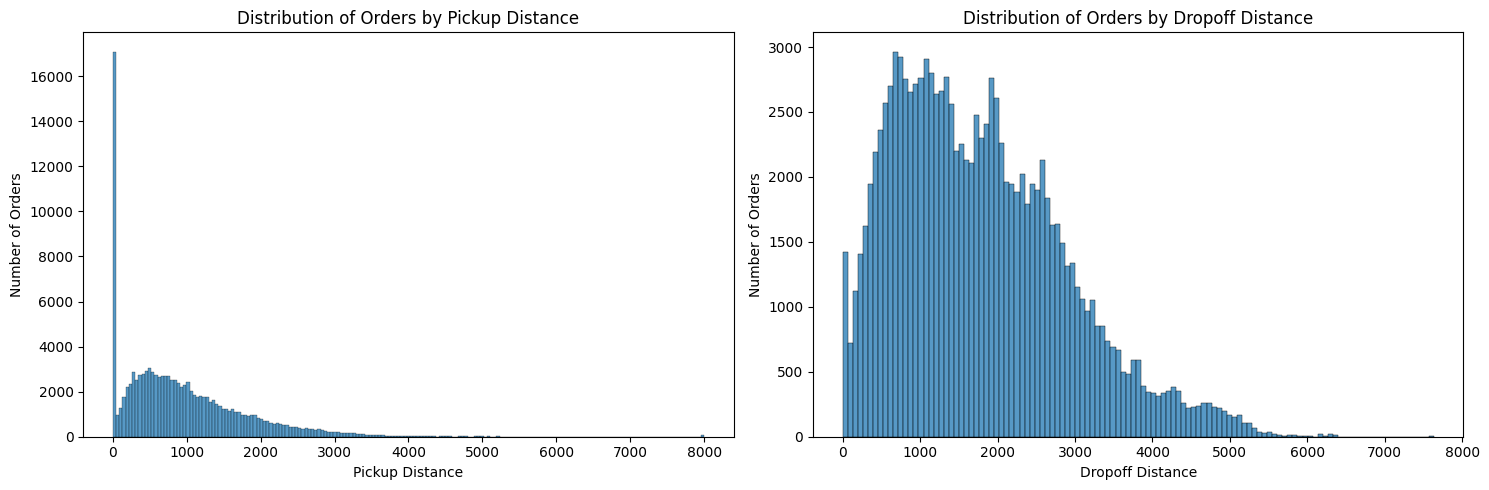

In [ ]:
# prompt: From df, show me the distribution of numbers of orders per pickup_distance and per dropoff_distance, on two different graphs. Cap the distances at 8000

import matplotlib.pyplot as plt
import seaborn as sns

# Cap the distances at 8000
df['pickup_distance'] = df['pickup_distance'].clip(upper=8000)
df['dropoff_distance'] = df['dropoff_distance'].clip(upper=8000)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot the distribution of orders per pickup distance
sns.histplot(data=df, x='pickup_distance', ax=axes[0])
axes[0].set_title('Distribution of Orders by Pickup Distance')
axes[0].set_xlabel('Pickup Distance')
axes[0].set_ylabel('Number of Orders')


# Plot the distribution of orders per dropoff distance
sns.histplot(data=df, x='dropoff_distance', ax=axes[1])
axes[1].set_title('Distribution of Orders by Dropoff Distance')
axes[1].set_xlabel('Dropoff Distance')
axes[1].set_ylabel('Number of Orders')


plt.tight_layout()
plt.show()


In [ ]:
# prompt: Give me the min, max, median and average for pickup_distance and dropoff_distance in df

# Calculate min, max, median, and average for pickup_distance and dropoff_distance
stats_distance = df[['pickup_distance', 'dropoff_distance']].agg(['min', 'max', 'median', 'mean'])

# Display the results
print(stats_distance)


        pickup_distance  dropoff_distance
min            0.000000          0.000000
max         8000.000000       7635.000000
median       764.000000       1634.000000
mean         940.142455       1785.698971


In [ ]:
# Export df to google sheets using spreadsheet_id

from google.colab import auth
auth.authenticate_user()
import gspread
from google.auth import default
from gspread_dataframe import set_with_dataframe

creds, _ = default()
gc = gspread.authorize(creds)

spreadsheet_id = '1M_84DSRxwJ8vSGl2c84uKh4Z-X62C_GtGedVe4D7zFU'
sheet_name = 'data'

# Open the spreadsheet and select the worksheet
sh = gc.open_by_key(spreadsheet_id)
worksheet = sh.worksheet(sheet_name)

# Clear existing data in the worksheet
worksheet.clear()

# Export the DataFrame to Google Sheets
set_with_dataframe(worksheet, df)


In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import differential_evolution

# Define Buckets (each bucket covers a specific range of distances)
buckets = [(1500, 2000), (2000, 2500), (2500, 3000), (3000, float('inf'))]

# Objective function to minimize the difference from the target average total (3900)
def objective_function(bonus_per_100m):
    # Ensure all bonus_per_100m values are strictly positive and increase by at least 20 per bucket
    bonus_per_100m = np.maximum(20, bonus_per_100m)
    for i in range(1, len(bonus_per_100m)):
        bonus_per_100m[i] = np.maximum(bonus_per_100m[i], bonus_per_100m[i - 1] + 20)

    df['bonus_distance'] = 0.0  # Initialize with a float type

    # Calculate bonus for all previous buckets cumulatively
    for i, (start, end) in enumerate(buckets):
        # Mask to select rows that fall into the current bucket
        if end == float('inf'):
            mask = df['dropoff_distance'] > start
        else:
            mask = (df['dropoff_distance'] > start) & (df['dropoff_distance'] <= end)

        # Apply bonuses for every 100m segment, and sum from all previous buckets
        for j in range(i + 1):  # This ensures we're summing from bucket 0 to current bucket i
            previous_start = buckets[j][0]
            previous_end = buckets[j][1] if buckets[j][1] != float('inf') else df['dropoff_distance'].max()

            # Bonus is calculated for each 100m step between the start of the previous bucket and the dropoff distance
            bonus_segments = (np.minimum(df.loc[mask, 'dropoff_distance'], previous_end) - previous_start) // 100
            df.loc[mask, 'bonus_distance'] += bonus_segments * bonus_per_100m[j]

    # Calculate the total (basic pay + distance bonus)
    df['total'] = df['total_basic_pay'] + df['bonus_distance']
    avg_total = df['total'].mean()

    return (avg_total - 3900) ** 2

# Bounds for bonus values (strictly positive, minimum of 20 and maximum of 250)
bounds = [(20, 250)] * len(buckets)

# Perform the optimization using differential evolution
result = differential_evolution(objective_function, bounds=bounds)

# Extract the optimized bonus values per 100m for each bucket
optimal_bonus_per_100m = result.x

# Calculate the final bonus and total using the optimized bonus values
df['bonus_distance'] = 0.0  # Initialize bonus_distance as float
for i, (start, end) in enumerate(buckets):
    if end == float('inf'):
        mask = df['dropoff_distance'] > start
    else:
        mask = (df['dropoff_distance'] > start) & (df['dropoff_distance'] <= end)

    # Apply bonuses cumulatively for all previous buckets
    for j in range(i + 1):
        previous_start = buckets[j][0]
        previous_end = buckets[j][1] if buckets[j][1] != float('inf') else df['dropoff_distance'].max()

        bonus_segments = (np.minimum(df.loc[mask, 'dropoff_distance'], previous_end) - previous_start) // 100
        df.loc[mask, 'bonus_distance'] += bonus_segments * optimal_bonus_per_100m[j]

# Calculate the final total (basic pay + bonus distance)
df['total'] = df['total_basic_pay'] + df['bonus_distance']

# Output the results
print(f"Optimal bonus per 100m: {optimal_bonus_per_100m}")
print(f"Average total: {df['total'].mean()}")
print(df)


Optimal bonus per 100m: [ 24.35208954  43.37406689  75.67700147 112.83931931]
Average total: 3898.53279273874
          tag    date_kst time_kst  is_stacked  order_id payment_type  \
0       nstod  2024-09-01    18:01       False   2246098     DELIVERY   
1        stod  2024-09-01    14:25       False   2244410     DELIVERY   
2       nstod  2024-08-31    19:07       False   2240278     DELIVERY   
3        stod  2024-09-01    13:46       False   2244103     DELIVERY   
4        stod  2024-09-01    20:52       False   2247855     DELIVERY   
...       ...         ...      ...         ...       ...          ...   
115700  nstod  2024-08-31    18:41       False   2239898     DELIVERY   
115701  nstod  2024-08-22    19:23       False   2201189     DELIVERY   
115702  nstod  2024-08-24    22:32       False   2211481     DELIVERY   
115703  nstod  2024-08-23    17:56       False   2204241     DELIVERY   
115704  nstod  2024-08-24    23:13       False   2211574     DELIVERY   

       vehicl

In [ ]:
# Display Results
print(f"Optimal bonus per 100m: {optimal_bonus_per_100m}")
print(f"Average total: {df['total'].mean()}")
print(df)

Optimal bonus per 100m: [ 24.35208954  43.37406689  75.67700147 112.83931931]
Average total: 3898.53279273874
          tag    date_kst time_kst  is_stacked  order_id payment_type  \
0       nstod  2024-09-01    18:01       False   2246098     DELIVERY   
1        stod  2024-09-01    14:25       False   2244410     DELIVERY   
2       nstod  2024-08-31    19:07       False   2240278     DELIVERY   
3        stod  2024-09-01    13:46       False   2244103     DELIVERY   
4        stod  2024-09-01    20:52       False   2247855     DELIVERY   
...       ...         ...      ...         ...       ...          ...   
115700  nstod  2024-08-31    18:41       False   2239898     DELIVERY   
115701  nstod  2024-08-22    19:23       False   2201189     DELIVERY   
115702  nstod  2024-08-24    22:32       False   2211481     DELIVERY   
115703  nstod  2024-08-23    17:56       False   2204241     DELIVERY   
115704  nstod  2024-08-24    23:13       False   2211574     DELIVERY   

       vehicl

In [ ]:
df.head(10)

,tag,date_kst,time_kst,is_stacked,order_id,payment_type,vehicle_type,pickup_distance,dropoff_distance,PAY_PICKEDUP_DELIVERIES,...,PAY_DROPOFF_DISTANCES,PAY_COMPLETED_DELIVERIES,delivery_count,total_won,basic_pickup_pay,basic_dropoff_distance_pay,basic_neardropoff_pay,total_basic_pay,bonus_distance,total
0,nstod,2024-09-01,18:01,False,2246098,DELIVERY,Motorbike,173,5082,0E-9,...,3060.000000000,0E-9,34,6060.000000000,0,3060.0,3000,6060.0,2973.802176,9033.802176
1,stod,2024-09-01,14:25,False,2244410,DELIVERY,Motorbike,889,3779,1100.000000000,...,3040.000000000,0E-9,40,5140.000000000,1100,3040.0,1000,5140.0,1506.891025,6646.891025
2,nstod,2024-08-31,19:07,False,2240278,DELIVERY,Motorbike,1325,3609,0E-9,...,1940.000000000,0E-9,20,4940.000000000,0,1940.0,3000,4940.0,1394.051705,6334.051705
3,stod,2024-09-01,13:46,False,2244103,DELIVERY,Car,14,263,1100.000000000,...,210.000000000,0E-9,5,2310.000000000,1100,240.0,1000,2340.0,0.000000,2340.000000
4,stod,2024-09-01,20:52,False,2247855,DELIVERY,Bicycle,756,823,1100.000000000,...,630.000000000,0E-9,11,2730.000000000,1100,720.0,1000,2820.0,0.000000,2820.000000
5,nstod,2024-09-06,17:25,False,2265990,DELIVERY,Motorbike,590,3396,0E-9,...,1700.000000000,0E-9,17,4700.000000000,0,1700.0,3000,4700.0,1055.533747,5755.533747
6,stod,2024-08-26,20:37,True,2219912,DELIVERY,Motorbike,0,3971,1100.000000000,...,3200.000000000,0E-9,42,5300.000000000,1100,3200.0,1000,5300.0,1732.569663,7032.569663
7,nstod,2024-08-28,20:27,False,2227338,DELIVERY,Motorbike,2467,3560,0E-9,...,1860.000000000,0E-9,19,4860.000000000,0,1860.0,3000,4860.0,1281.212386,6141.212386
8,stod,2024-09-09,12:33,False,2280927,DELIVERY,Motorbike,86,3657,1100.000000000,...,2960.000000000,0E-9,39,5060.000000000,1100,2960.0,1000,5060.0,1394.051705,6454.051705
9,nstod,2024-08-27,16:15,False,2221903,DELIVERY,Motorbike,2324,3763,0E-9,...,2020.000000000,0E-9,21,5020.000000000,0,2020.0,3000,5020.0,1506.891025,6526.891025


In [ ]:
# prompt: From df, calculate the average, median, min and max of total_won

avg_total_won = df['total_won'].mean()
median_total_won = df['total_won'].median()
min_total_won = df['total_won'].min()
max_total_won = df['total_won'].max()

print(f"Average total_won: {avg_total_won}")
print(f"Median total_won: {median_total_won}")
print(f"Minimum total_won: {min_total_won}")
print(f"Maximum total_won: {max_total_won}")


Average total_won: 3608.2142609238886
Median total_won: 3500.0
Minimum total_won: 1100.000000000
Maximum total_won: 14220.000000000


In [ ]:
# prompt: display length of df and count of unique order_id

print(f"Length of DataFrame: {len(df)}")
print(f"Number of unique order IDs: {df['order_id'].nunique()}")


Length of DataFrame: 64789
Number of unique order IDs: 64496


In [ ]:
# prompt: Display the values of payment_type

print(df['payment_type'].unique())


['DELIVERY']


In [ ]:
# prompt: From df, get unique values from the column sub_type

unique_sub_types = df['sub_type'].unique()
print(unique_sub_types)


['PICKEDUP_DELIVERIES' 'DROPOFF_DISTANCES' 'COMPLETED_DELIVERIES'
 'NEAR_DROPOFF_DELIVERIES']


In [ ]:
# Distance distribution per vehicle
df_orders= client.query('''
SELECT
order_id,
vehicle.name,
CASE
    WHEN EXISTS(SELECT 1 FROM UNNEST(tags) AS t WHERE t = 'nstod') THEN 'nstod'
    WHEN EXISTS(SELECT 1 FROM UNNEST(tags) AS t WHERE t = 'stod') THEN 'stod'
    ELSE NULL
END AS tag,
d.delivery_distance, --check the definition
o.timings.actual_delivery_time/60 as actual_delivery_time,
o.timings.rider_accepting_time/60 as rider_accepting_time,
from fulfillment-dwh-production.curated_data_shared.orders o
LEFT JOIN  UNNEST(deliveries) d ON d.is_primary
where country_code='kr2'
and o.city_id=2
and d.delivery_status='completed'
and DATE(created_date) BETWEEN '2024-08-19' AND '2024-09-15' --last 4 weeks excluding holidays
--and EXTRACT(DAYOFWEEK FROM created_date) BETWEEN 2 AND 6 -- Monday to Friday
''').to_dataframe()
df_orders.head()

,order_id,name,tag,delivery_distance,actual_delivery_time,rider_accepting_time
0,2221317,Car,nstod,4432,61.166667,33.933333
1,2221143,Car,nstod,4860,46.033333,26.316667
2,2221598,Car,stod,2865,77.916667,42.116667
3,2221526,Car,nstod,2384,79.600000,58.900000
4,2221026,Car,stod,4020,92.833333,48.400000


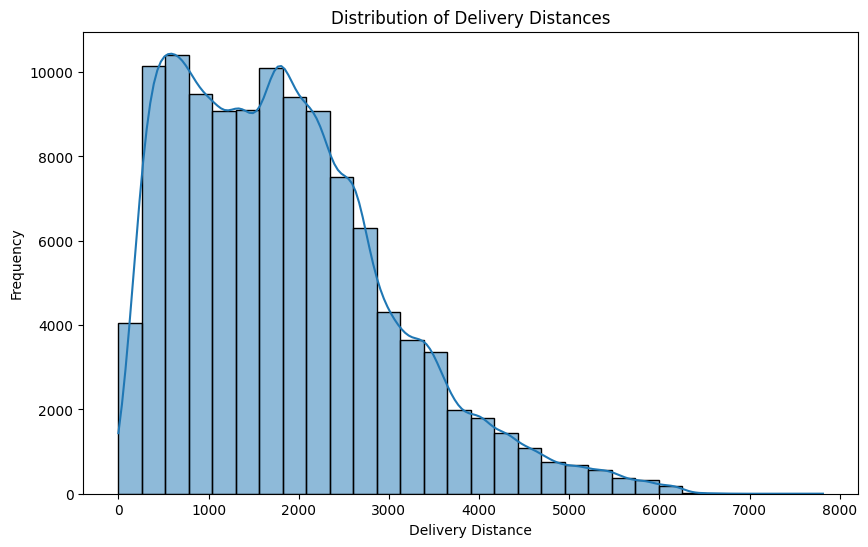

In [ ]:
#From df_orders visualise the distribution of delivery_distances

import matplotlib.pyplot as plt
import seaborn as sns

# Create a histogram of delivery distances
plt.figure(figsize=(10, 6))
sns.histplot(df_orders['delivery_distance'], bins=30, kde=True)
plt.title('Distribution of Delivery Distances')
plt.xlabel('Delivery Distance')
plt.ylabel('Frequency')
plt.show()


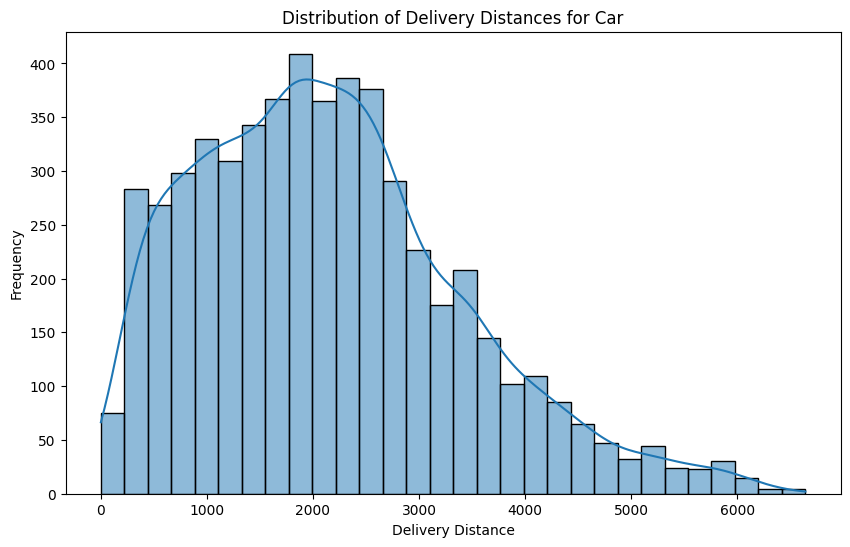

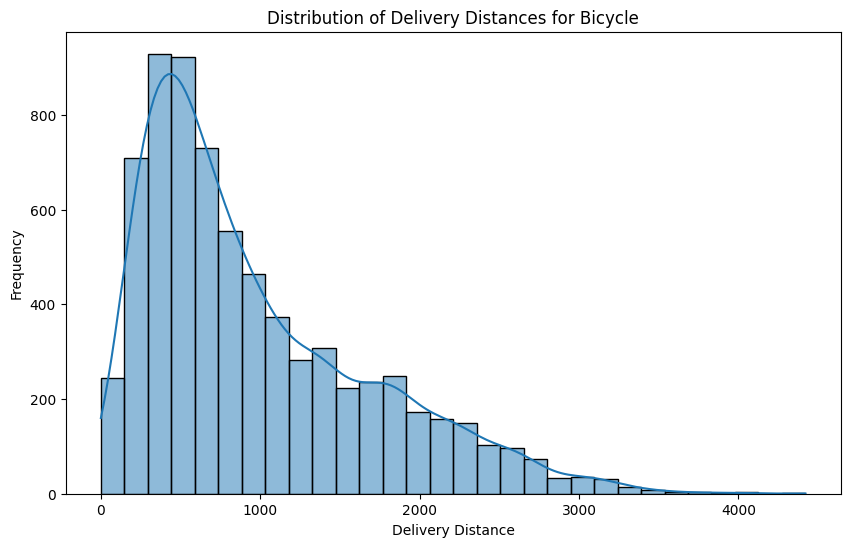

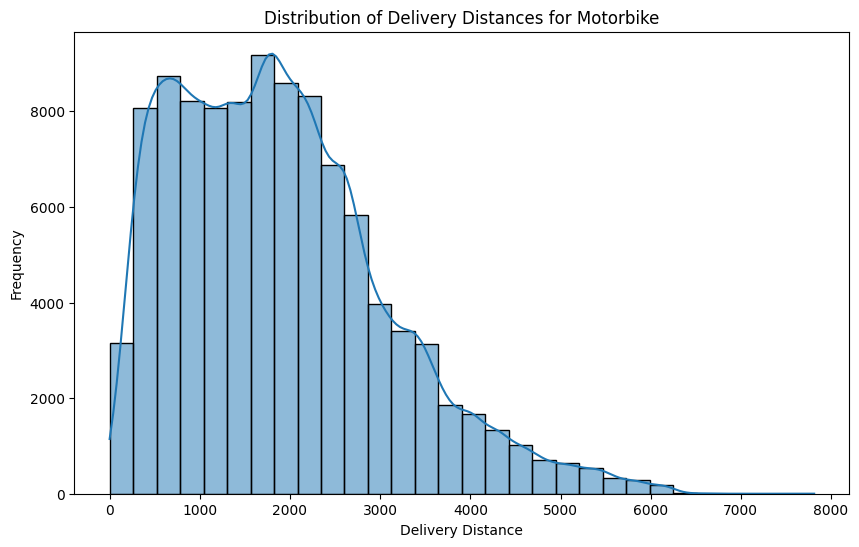

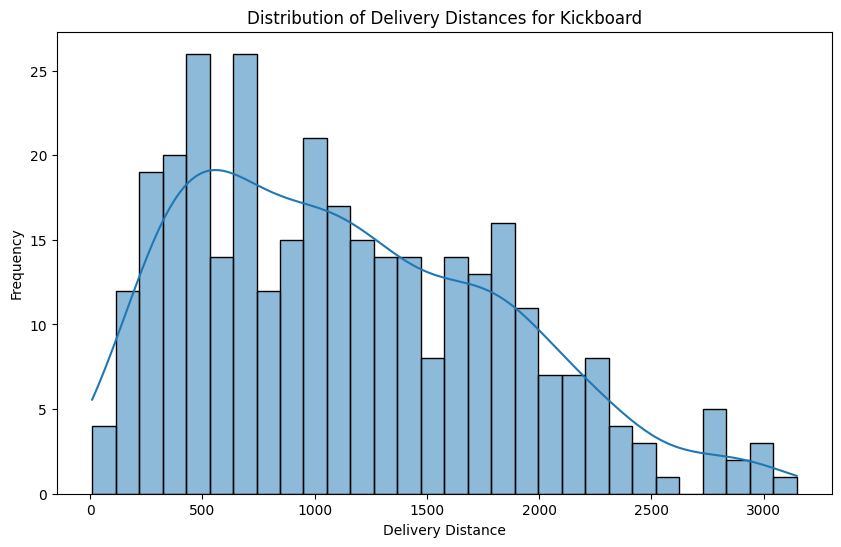

In [ ]:
# prompt: From df_orders visualise the distribution of delivery_distances. Split per name, with one graph per name, exclude name=Walker.

import matplotlib.pyplot as plt
import seaborn as sns

# Filter out rows where name is 'Walker'
df_filtered = df_orders[df_orders['name'] != 'Walker']

# Get unique vehicle names
vehicle_names = df_filtered['name'].unique()

# Create a histogram of delivery distances for each vehicle name
for name in vehicle_names:
  df_vehicle = df_filtered[df_filtered['name'] == name]
  plt.figure(figsize=(10, 6))
  sns.histplot(df_vehicle['delivery_distance'], bins=30, kde=True)
  plt.title(f'Distribution of Delivery Distances for {name}')
  plt.xlabel('Delivery Distance')
  plt.ylabel('Frequency')
  plt.show()


In [ ]:
# Distance distribution per vehicle
df_orders_acceptance= client.query('''
SELECT
o.order_id,
vehicle.name,
CASE
    WHEN EXISTS(SELECT 1 FROM UNNEST(tags) AS t WHERE t = 'nstod') THEN 'nstod'
    WHEN EXISTS(SELECT 1 FROM UNNEST(tags) AS t WHERE t = 'stod') THEN 'stod'
    ELSE NULL
END AS tag,
d.delivery_distance,
d.timings.actual_delivery_time/60 as actual_delivery_time,
d.timings.rider_accepting_time/60 as rider_accepting_time,
rider_accepted_count,
manual_undispatched_count,
rider_notified_count
from fulfillment-dwh-production.curated_data_shared.orders o
LEFT JOIN  UNNEST(deliveries) d ON d.is_primary
LEFT JOIN fulfillment-dwh-production.cl.acceptance_rate_deliveries ard ON o.order_id = ard.order_id
where o.country_code='kr2'
and o.city_id=2
and d.delivery_status='completed'
and DATE(created_date) BETWEEN '2024-08-19' AND '2024-09-15' --last 4 weeks excluding holidays
--and EXTRACT(DAYOFWEEK FROM created_date) BETWEEN 2 AND 6 -- Monday to Friday
''').to_dataframe()
df_orders_acceptance.head()

,order_id,name,tag,delivery_distance,actual_delivery_time,rider_accepting_time,rider_accepted_count,manual_undispatched_count,rider_notified_count
0,2218010,Motorbike,stod,1060,33.8,26.133333,1,0,1
1,2218010,Motorbike,stod,1060,33.8,26.133333,1,0,1
2,2218010,Motorbike,stod,1060,33.8,26.133333,0,0,1
3,2218010,Motorbike,stod,1060,33.8,26.133333,0,0,1
4,2218010,Motorbike,stod,1060,33.8,26.133333,0,0,1


In [ ]:
## Query from the dashboard

df = client.query('''
WITH order_stream AS (
  SELECT global_entity_id
    , content.order_id
  FROM `fulfillment-dwh-production.curated_data_shared_data_stream.order_status_stream`
  WHERE timestamp BETWEEN '2024-08-19' AND '2024-09-15' -- to be able to do DoD comparison from one week ago
    AND global_entity_id = 'BM_KR'
    -- find all orders that have some Hurrier or OTv2 events. this is expected to include all Osan-si orders currently.
    AND metadata.source IN ('HURRIER', 'rps')
  GROUP BY 1,2
), status_events AS ( -- order status stream
  SELECT s.global_entity_id
    , content.order_id
    , content.vendor.id AS vendor_id
    , MIN(CASE WHEN metadata.source = 'rps' AND content.status = 'SENT_TO_LOGISTICS' THEN content.timestamp END) AS order_created_at
    , MIN(CASE WHEN metadata.source = 'HURRIER' AND content.status = 'COURIER_ACCEPTED_DELIVERY' THEN content.timestamp END) AS order_accepted_at
    , MIN(CASE WHEN metadata.source = 'HURRIER' AND content.status = 'COURIER_NEAR_PICK_UP' THEN content.timestamp END) AS order_near_pickup_at
    , MIN(CASE WHEN metadata.source = 'HURRIER' AND content.status = 'PICKED_UP' THEN content.timestamp END) AS order_picked_up_at
    , MIN(CASE WHEN metadata.source = 'HURRIER' AND content.status = 'COURIER_NEAR_DROP_OFF' THEN content.timestamp END) AS order_near_dropoff_at
    , MIN(CASE WHEN metadata.source = 'HURRIER' AND content.status = 'DELIVERED' THEN content.timestamp END) AS order_delivered_at
    , MIN(CASE WHEN content.status = 'CANCELLED' THEN content.timestamp END) AS order_cancelled_at
    , MAX(CASE WHEN content.status = 'CANCELLED' THEN content.cancelled.details.owner END) AS cancellation_owner
    , MAX(CASE WHEN content.status = 'CANCELLED' THEN content.cancelled.details.reason END) AS cancellation_reason
    , MAX(CASE WHEN content.status = 'CANCELLED' THEN content.cancelled.details.stage END) AS cancellation_stage
    , MAX(CASE WHEN content.status = 'CANCELLED' THEN content.cancelled.details.source END) AS cancellation_source
    , MAX(CASE WHEN content.status = 'CANCELLED' THEN content.cancelled.details.local_reason END) AS cancellation_local_reason
  FROM `fulfillment-dwh-production.curated_data_shared_data_stream.order_status_stream` s
  INNER JOIN order_stream o ON s.global_entity_id = o.global_entity_id
    AND s.content.order_id = o.order_id
  WHERE s.timestamp BETWEEN '2024-08-19' AND '2024-09-15' -- to be able to do DoD comparison from one week ago
    AND s.global_entity_id = 'BM_KR'
  GROUP BY 1,2,3
), local_times AS (
  SELECT global_entity_id
    , order_id
    , vendor_id
    , DATE(order_created_at, 'Asia/Seoul') AS created_date
    , DATETIME(order_created_at, 'Asia/Seoul') AS order_created_at
    , DATETIME(order_accepted_at, 'Asia/Seoul') AS order_accepted_at
    , DATETIME(order_near_pickup_at, 'Asia/Seoul') AS order_near_pickup_at
    , DATETIME(order_picked_up_at, 'Asia/Seoul') AS order_picked_up_at
    , DATETIME(order_near_dropoff_at, 'Asia/Seoul') AS order_near_dropoff_at
    , DATETIME(order_delivered_at, 'Asia/Seoul') AS order_delivered_at
    , DATETIME(IF(order_cancelled_at <= COALESCE(order_delivered_at, order_cancelled_at), order_cancelled_at, NULL), 'Asia/Seoul') AS order_cancelled_at
    , order_delivered_at IS NOT NULL AS is_order_delivered
    , IF(order_cancelled_at <= COALESCE(order_delivered_at, order_cancelled_at), TRUE, FALSE) AS is_order_cancelled
    , cancellation_owner
    , cancellation_reason
    , cancellation_stage
    , cancellation_source
    , cancellation_local_reason
  FROM status_events
  WHERE order_created_at IS NOT NULL -- possible way to exclude VD orders
), dt_calculations AS (
  SELECT l.*
    , 'OSAN-SI' AS city_code -- hardcoding because order_stream lookup isn't feasible
    , 'Osan-si' AS city_name -- hardcoding because order_stream lookup isn't feasible
    , FALSE is_preorder -- hardcoding because order_stream lookup isn't feasible
    , DATETIME_DIFF(l.order_accepted_at, l.order_created_at, SECOND) AS to_accept_seconds
    , DATETIME_DIFF(l.order_near_pickup_at, l.order_accepted_at, SECOND) AS to_vendor_seconds
    , DATETIME_DIFF(l.order_picked_up_at, l.order_near_pickup_at, SECOND) AS at_vendor_seconds
    , DATETIME_DIFF(l.order_near_dropoff_at, l.order_picked_up_at, SECOND) AS to_customer_seconds
    , DATETIME_DIFF(l.order_delivered_at, l.order_near_dropoff_at, SECOND) AS at_customer_seconds
    , DATETIME_DIFF(l.order_cancelled_at, l.order_created_at, SECOND) AS to_cancel_seconds
    , DATETIME_DIFF(COALESCE(l.order_near_dropoff_at, l.order_delivered_at), order_created_at, SECOND) AS delivery_time_dh_seconds
    , NULL AS promised_delivery_time_seconds -- hardcoding because order_stream lookup isn't feasible
    , DATETIME_DIFF(l.order_delivered_at, l.order_created_at, SECOND) AS delivery_time_glovo_seconds
    , IF(NOT is_order_delivered AND NOT is_order_cancelled, DATETIME_DIFF(DATETIME(CURRENT_TIMESTAMP, 'Asia/Seoul'), order_created_at, SECOND), NULL) AS active_order_duration_seconds
  FROM local_times l
  INNER JOIN order_stream o ON l.global_entity_id = o.global_entity_id -- using INNER JOIN as order_status_stream doesn't have city_id to filter
    AND l.order_id = o.order_id
), final AS (
  SELECT dt.*
    , p.* EXCEPT(order_id)
  FROM dt_calculations dt
  LEFT JOIN `fulfillment-dwh-production.cl._live_basic_payments` p ON p.country_code = 'kr2'
    AND dt.order_id = p.order_id
)
SELECT *
FROM final
''').to_dataframe()
df.head(10)

,global_entity_id,order_id,vendor_id,created_date,order_created_at,order_accepted_at,order_near_pickup_at,order_picked_up_at,order_near_dropoff_at,order_delivered_at,...,delivery_time_glovo_seconds,active_order_duration_seconds,country_code,multiplier_value,pickup_payments_local,distance_payments_local,dropoff_payments_local,pickup_payments_eur,distance_payments_eur,dropoff_payments_eur
0,BM_KR,T1VK000039LQ,14416397,2024-08-29,2024-08-29 08:46:51.456,2024-08-29 08:50:08.984,2024-08-29 09:01:07.529,2024-08-29 09:02:46.073,2024-08-29 09:10:27.718,2024-08-29 09:12:25.102,...,1534,<NA>,None,NaN,None,None,None,None,None,None
1,BM_KR,T1VS00002T70,14439035,2024-09-06,2024-09-06 08:03:01.098,2024-09-06 08:03:29.900,2024-09-06 08:13:04.011,2024-09-06 08:20:05.643,2024-09-06 08:32:54.463,2024-09-06 08:36:18.905,...,1997,<NA>,None,NaN,None,None,None,None,None,None
2,BM_KR,T1VI00003A2Y,14361037,2024-08-27,2024-08-27 07:20:50.503,2024-08-27 07:58:08.561,2024-08-27 07:59:26.904,2024-08-27 07:59:50.138,2024-08-27 08:15:07.682,2024-08-27 08:15:43.180,...,3293,<NA>,None,NaN,None,None,None,None,None,None
3,BM_KR,T1VI00001CFO,14353007,2024-08-27,2024-08-27 02:08:55.316,2024-08-27 02:19:23.723,2024-08-27 02:21:30.428,2024-08-27 02:29:40.133,2024-08-27 02:31:26.476,2024-08-27 02:32:44.761,...,1429,<NA>,None,NaN,None,None,None,None,None,None
4,BM_KR,151333506,13699430,2024-08-27,2024-08-27 08:42:39.358,2024-08-27 09:01:50.610,2024-08-27 09:13:27.178,2024-08-27 09:14:39.278,2024-08-27 09:24:27.086,2024-08-27 09:25:50.877,...,2591,<NA>,None,NaN,None,None,None,None,None,None
5,BM_KR,151333505,13699430,2024-08-27,2024-08-27 08:42:38.534,2024-08-27 09:01:50.782,2024-08-27 09:13:27.244,2024-08-27 09:14:32.645,2024-08-27 09:24:27.030,2024-08-27 09:25:27.351,...,2569,<NA>,None,NaN,None,None,None,None,None,None
6,BM_KR,T1VE00001OXU,13661690,2024-08-23,2024-08-23 08:25:24.650,2024-08-23 08:40:44.055,2024-08-23 09:04:31.743,2024-08-23 09:04:54.349,2024-08-23 09:07:21.474,2024-08-23 09:09:57.035,...,2673,<NA>,None,NaN,None,None,None,None,None,None
7,BM_KR,T1VW00003349,14212431,2024-09-10,2024-09-10 07:10:16.062,2024-09-10 07:39:44.593,2024-09-10 07:41:17.431,2024-09-10 07:41:47.142,2024-09-10 07:42:17.427,2024-09-10 07:43:18.292,...,1982,<NA>,None,NaN,None,None,None,None,None,None
8,BM_KR,T1VW0000335B,14595251,2024-09-10,2024-09-10 07:28:14.694,2024-09-10 07:29:06.309,2024-09-10 07:31:17.149,2024-09-10 07:33:17.913,2024-09-10 07:39:26.551,2024-09-10 07:41:59.033,...,825,<NA>,None,NaN,None,None,None,None,None,None
9,BM_KR,T1VW000048T9,14396697,2024-09-10,2024-09-10 08:25:03.692,2024-09-10 08:31:10.607,2024-09-10 08:34:07.051,2024-09-10 08:34:23.659,2024-09-10 08:43:37.382,2024-09-10 08:46:34.297,...,1291,<NA>,None,NaN,None,None,None,None,None,None


In [ ]:
# Fail Rate

df_fail = client.query('''
WITH orders_dataset AS (
SELECT o.country_code
 , COALESCE(DATE(d.rider_dropped_off_at, o.timezone), DATE(d.created_at, o.timezone)) AS report_date
 , FORMAT_DATE('%G-%V', COALESCE(DATE(d.rider_dropped_off_at, o.timezone), DATE(d.created_at, o.timezone))) AS report_week
 , FORMAT_DATE('%Y-%m', COALESCE(DATE(d.rider_dropped_off_at, o.timezone), DATE(d.created_at, o.timezone))) AS report_month
 , o.order_id
 , d.delivery_status
 , o.order_status
FROM fulfillment-dwh-production.curated_data_shared.orders o
LEFT JOIN  UNNEST(deliveries) d ON d.is_primary
WHERE o.created_date >= '2024-04-01'
AND o.country_code='my'
AND COALESCE(DATE(d.rider_dropped_off_at, o.timezone), DATE(d.created_at, o.timezone)) >= '2024-05-01'
), filtered_dataset AS (

SELECT country_code
 , report_date
 , report_week
 , report_month
 , IF(delivery_status = 'completed', order_id, NULL) AS order_completed
 , IF(order_status = 'cancelled', order_id, NULL) AS order_cancelled
FROM orders_dataset

)

SELECT country_code
 , report_date
 , report_week
 , report_month
 , COUNT(order_completed) AS orders_completed
 , COUNT(order_cancelled) AS orders_cancelled
 , COUNT(order_completed) + COUNT(order_cancelled) AS gross_orders
 , ROUND(SAFE_DIVIDE(COUNT(order_cancelled),  COUNT(order_completed) + COUNT(order_cancelled)), 3) * 100 AS fail_rate
FROM filtered_dataset
WHERE report_date = '2024-05-25'
GROUP BY 1, 2, 3, 4
''').to_dataframe()
df.he